# Importing Necessary Modules

In [3]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
sb.set()

fashiondata_raw = pd.read_csv('fashion_data_2018_2022.csv')
fashiondata_extracted = pd.DataFrame(fashiondata_raw[["gender", "color", "price", "material", "year_of_sale", "age_group", "season", "category", "sales_count", "average_rating"]])

df = fashiondata_extracted.groupby(['year_of_sale', 'season', 'category']).sum()
pivoted = pd.pivot_table(df, values='sales_count', index=['year_of_sale', 'season'], columns=['category'])
pivoted = pivoted.fillna(0).astype(int)

summed_sales = pivoted.sum(axis=1)
finaldataset = pd.DataFrame(summed_sales, columns=['total_sales'])

# Using One Hot Encoder for Categorical Predictors

In [4]:
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
fashiondata_extracted_cat = fashiondata_extracted[['material','season', 'color', 'category']]
ohe.fit(fashiondata_extracted_cat)
fashiondata_extracted_cat_ohe = pd.DataFrame(ohe.transform(fashiondata_extracted_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(fashiondata_extracted_cat.columns))

fashiondata_extracted_num = fashiondata_extracted[['price','sales_count','average_rating', 'year_of_sale']]
fashiondata_extracted_res = fashiondata_extracted['gender']
fashiondata_ohe = pd.concat([fashiondata_extracted_num, fashiondata_extracted_cat_ohe, fashiondata_extracted_res], 
                           sort = False, axis = 1).reindex(index=fashiondata_extracted_num.index)

# Splitting Data into Train and Test Dataset

In [5]:
y = pd.DataFrame(fashiondata_ohe['gender'])
X = pd.DataFrame(fashiondata_ohe.drop('gender', axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Hyperparameter Tuning with Grid Search
### To obtain even higher accuracy, we perform Grid Search to optimize the hyper-parameters of our model

In [6]:
# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.gender.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
             scoring='accuracy')

### Fetching the Best Model/Set from Grid Search

In [7]:
print(hpGrid.best_estimator_)

best_n_estimators = hpGrid.best_params_['n_estimators']
print("Best n_estimators:", best_n_estimators)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=3, n_estimators=800)
Best n_estimators: 800
0.5373737373737374


# Using the Best Model from Grid Search for Random Forest

In [8]:
# Use the Best Model found through GridSearchCV

# Extract Response and Predictors
y = pd.DataFrame(fashiondata_ohe['gender'])
X = pd.DataFrame(fashiondata_ohe.drop('gender', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 600,   # found using GridSearchCV
                                 max_depth = 8)       # found using GridSearchCV

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.gender.ravel())

RandomForestClassifier(max_depth=8, n_estimators=600)

# Confusion Matrix and Performance Metrics for Training Data

Train Data
Accuracy  :	 0.9797979797979798

TPR Train :	 0.9921259842519685
TNR Train :	 0.966804979253112

FPR Train :	 0.03319502074688797
FNR Train :	 0.007874015748031496


<Axes: >

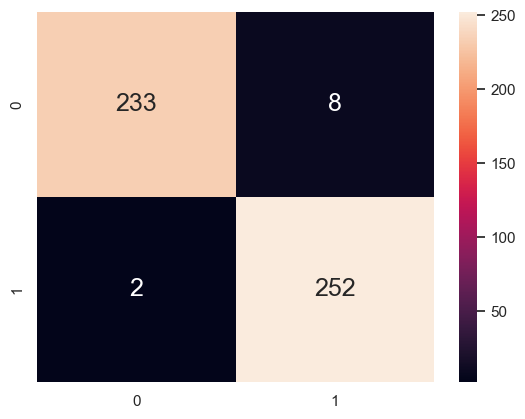

In [9]:
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix

sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# Confusion Matrix and Performance Metrics for Testing Data

Test Data
Accuracy  :	 0.49696969696969695

TPR Test :	 0.6266666666666667
TNR Test :	 0.3888888888888889

FPR Test :	 0.6111111111111112
FNR Test :	 0.37333333333333335


<Axes: >

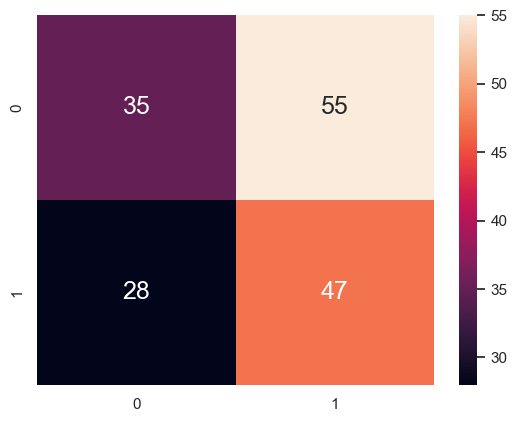

In [10]:
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})